In [ ]:
from src.evaluator import PecanEvaluator
from src.utils.functions import *
import torch
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing
from src.regressors.gru_regression import ConsumptionGRURegressor
from src.models.gru import GRUModel
from src.dataset import PecanDataset, PecanDataModule

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import pandas as pd

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args = dotdict()


args['task'] = 'test'

args['participant_id'] ='661_test_30'
args['root_path'] ='data/participants_data/1min/'

args['bidirectional'] = False
args['use_gpu'] = True
args['sequence_length'] = 60
args['n_hidden'] = 256
args['n_layers'] = 3
args['dropout'] = 0.2

args['activation_fn'] = 'sigmoid'
args['lr'] = 1e-5
args['num_workers'] = 1
args['batch_size'] = 32
args['n_epochs'] = 200
args['early_stopping'] = False
args['patience'] = 2

args['tst_activation_fn'] = 'gelu'
args['d_model'] = 128
args['n_head'] = 16
args['d_ffn'] = 256
args['max_seq_len'] = 120
args['d_k'] = 32
args['d_v'] = 32
args['res_dropout'] = 0.1
args['fc_dropout'] = 0.1

args['device'] = device

# models = ["LSTM", "Linear", "GRU", "RNN", "ConvRNN", "FCN", "TCN", "ResNet", "Transformer", "MLP", "TST"]
models = ["GRU"]
metrics = []
features_importances = []

In [ ]:
pecan_dataset = PecanParticipantPreProcessing(args['participant_id'], args['root_path'],
                                                   60)


[!] - Trainable dataframe shape - (129086, 28)
[*] Train dataframe shape: (90360, 28)
[*] Validation dataframe shape: (25817, 28)
[*] Test dataframe shape: (12909, 28)


100%|██████████████████████████████████████████████████████████████████████████| 25757/25757 [00:02<00:00, 9718.27it/s]


[!] Train sequence shape: (60, 28)
[!] Test sequence shape: (60, 28)
[!] Val sequence shape: (60, 28)
[!] Len of train, val and test sequence: 90300 25757 12849
[!] - Training shape:
[*] - Sequence shape: torch.Size([60, 28])
[*] - Lables shape: torch.Size([])
tensor(-0.3472)
[!] - Best Epoch - 193


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/mape': 0.23577043414115906,
 'test/rmse': 0.045462191104888916,
 'test/test_loss': 0.004356221295893192,
 'test/val_mae': 0.045462191104888916,
 'test/val_mse': 0.004356221295893192}
--------------------------------------------------------------------------------
[+] - Appending result:  {'test/test_loss': 0.004356221295893192, 'test/val_mae': 0.045462191104888916, 'test/val_mse': 0.004356221295893192, 'test/rmse': 0.045462191104888916, 'test/mape': 0.23577043414115906, 'model_name': 'GRU'}


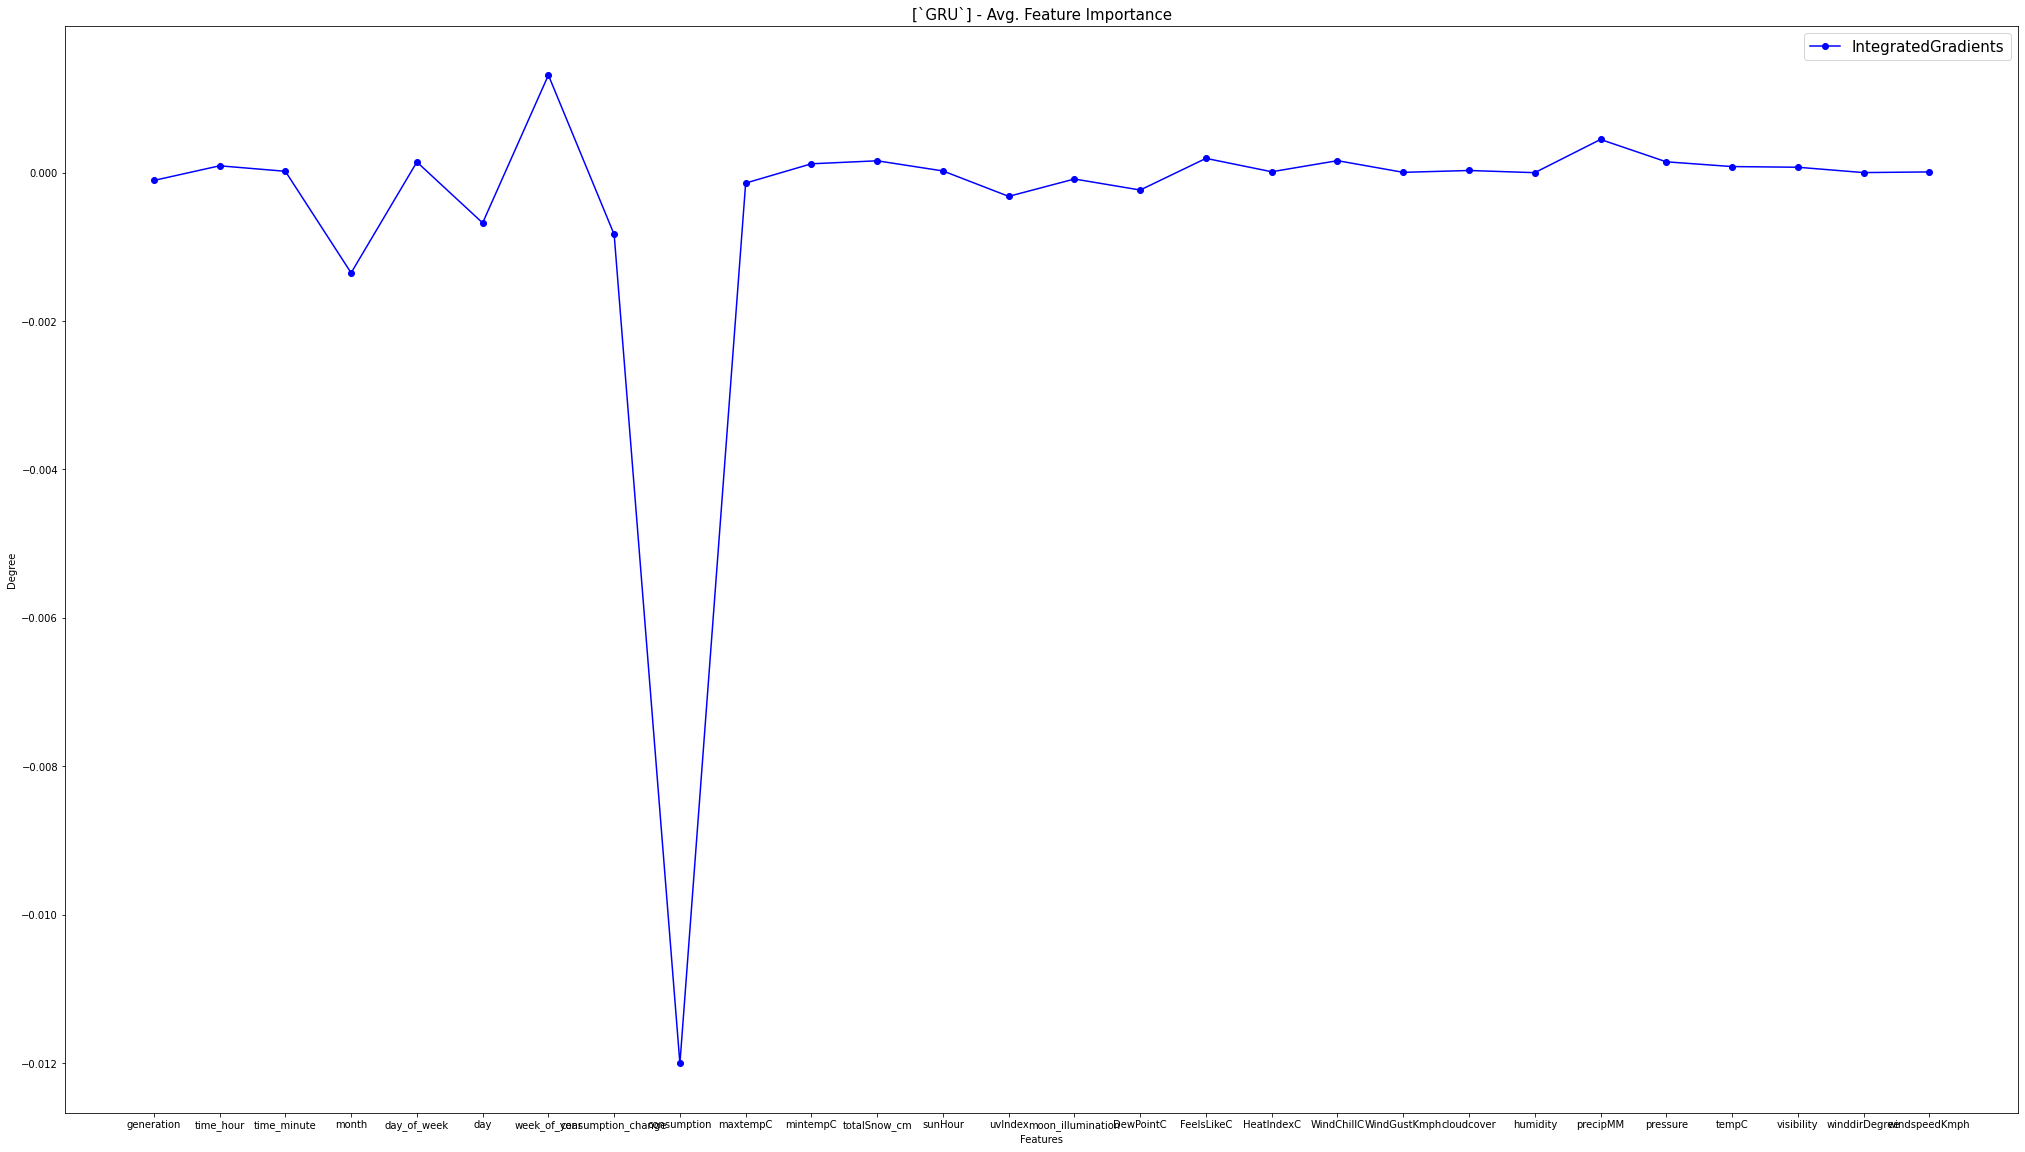

In [5]:
for model in models:
    args['model'] = model
    evaluator = PecanEvaluator(args)
    result = evaluator.eval()
    result[0]['model_name'] = model
    print("[+] - Appending result: ", result[0])
    metrics.append(result[0])
    features_importances.append({'model_name': model, 'feature_index': evaluator.get_importance_features()})

In [6]:
data = pd.DataFrame(metrics)
data

,test/test_loss,test/val_mae,test/val_mse,test/rmse,test/mape,model_name
0,0.004356,0.045462,0.004356,0.045462,0.23577,GRU


In [ ]:

x_pos = (np.arange(len(pecan_dataset.get_test_data().columns)))
features_importances


In [ ]:
plt.figure(figsize=(60, 20))
plt.title(f'Relationship between features weights', fontsize=30)

plt.plot(x_pos, np.mean(features_importances[0]['feature_index']['IntegratedGradients'], axis=0), 's-', label='LSTM-IntegratedGradients',
         color='red')
plt.plot(x_pos, np.mean(features_importances[1]['feature_index']['IntegratedGradients'], axis=0), 'o-', label='GRU-IntegratedGradients',
         color='blue')
plt.plot(x_pos, np.mean(features_importances[2]['feature_index']['IntegratedGradients'], axis=0), '^-', label='Transformer-IntegratedGradients',
         color='green')
plt.xticks(x_pos, pecan_dataset.get_test_data().columns, wrap=True, fontsize=20, rotation=30, va='center_baseline')
plt.yticks(fontsize=20)
plt.xlabel('Features')
plt.ylabel('Degree')
plt.legend(fontsize=20)
plt.savefig(f'etc/imgs/features/feature_importance_relationship_LSTM_GRU_Trans_661_test_32.svg', dpi=600, bbox_inches='tight')
